In [14]:
# https://docs.ray.io/en/latest/tune/tutorials/tune-tutorial.html
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import SqueezeNet
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import tune
from ray.tune.schedulers import ASHAScheduler

#Visulization
import matplotlib.pyplot as plt

In [19]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [20]:
# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE = 512
#TEST_SIZE = 256

def train(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test(model, data_loader): 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            #if batch_idx * len(data) > TEST_SIZE:
            #   break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [21]:
def train_mnist(config):
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST("~/data", train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)

        # Send the current training result back to Tune
        tune.report(mean_accuracy=acc)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")

In [22]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10**(-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9),
    # "choice": tune.choice(["a", "b", "c"]),
}

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
datasets.MNIST("~/data", train=True, download=True)

analysis = tune.run(train_mnist, config=search_space)


Trial name,status,loc,lr,momentum
train_mnist_0edff_00000,RUNNING,,4.39083e-07,0.730703


Result for train_mnist_0edff_00000:
  date: 2021-10-31_17-41-51
  done: false
  experiment_id: c1a10db8963c4651a7f418dd33ceb8db
  hostname: tobi-yoga
  iterations_since_restore: 1
  mean_accuracy: 0.1089
  node_ip: 10.80.1.25
  pid: 14440
  time_since_restore: 2.3471434116363525
  time_this_iter_s: 2.3471434116363525
  time_total_s: 2.3471434116363525
  timestamp: 1635694911
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0edff_00000
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_0edff_00000,RUNNING,10.80.1.25:14440,4.39083e-07,0.730703,0.1089,1,2.34714


Result for train_mnist_0edff_00000:
  date: 2021-10-31_17-41-58
  done: false
  experiment_id: c1a10db8963c4651a7f418dd33ceb8db
  hostname: tobi-yoga
  iterations_since_restore: 4
  mean_accuracy: 0.109
  node_ip: 10.80.1.25
  pid: 14440
  time_since_restore: 9.114607095718384
  time_this_iter_s: 2.294235944747925
  time_total_s: 9.114607095718384
  timestamp: 1635694918
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 0edff_00000
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_0edff_00000,RUNNING,10.80.1.25:14440,4.39083e-07,0.730703,0.109,4,9.11461


Result for train_mnist_0edff_00000:
  date: 2021-10-31_17-42-04
  done: false
  experiment_id: c1a10db8963c4651a7f418dd33ceb8db
  hostname: tobi-yoga
  iterations_since_restore: 7
  mean_accuracy: 0.109
  node_ip: 10.80.1.25
  pid: 14440
  time_since_restore: 15.289772748947144
  time_this_iter_s: 1.9543800354003906
  time_total_s: 15.289772748947144
  timestamp: 1635694924
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 0edff_00000
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_0edff_00000,RUNNING,10.80.1.25:14440,4.39083e-07,0.730703,0.109,7,15.2898


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_0edff_00000,RUNNING,10.80.1.25:14440,4.39083e-07,0.730703,0.109,9,19.3515


Result for train_mnist_0edff_00000:
  date: 2021-10-31_17-42-11
  done: false
  experiment_id: c1a10db8963c4651a7f418dd33ceb8db
  hostname: tobi-yoga
  iterations_since_restore: 10
  mean_accuracy: 0.109
  node_ip: 10.80.1.25
  pid: 14440
  time_since_restore: 22.243662357330322
  time_this_iter_s: 2.8921761512756348
  time_total_s: 22.243662357330322
  timestamp: 1635694931
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0edff_00000
  
Result for train_mnist_0edff_00000:
  date: 2021-10-31_17-42-11
  done: true
  experiment_id: c1a10db8963c4651a7f418dd33ceb8db
  experiment_tag: 0_lr=4.3908e-07,momentum=0.7307
  hostname: tobi-yoga
  iterations_since_restore: 10
  mean_accuracy: 0.109
  node_ip: 10.80.1.25
  pid: 14440
  time_since_restore: 22.243662357330322
  time_this_iter_s: 2.8921761512756348
  time_total_s: 22.243662357330322
  timestamp: 1635694931
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0edff_00000
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_0edff_00000,TERMINATED,,4.39083e-07,0.730703,0.109,10,22.2437


2021-10-31 17:42:11,954	INFO tune.py:617 -- Total run time: 24.24 seconds (24.06 seconds for the tuning loop).


[<AxesSubplot:>]

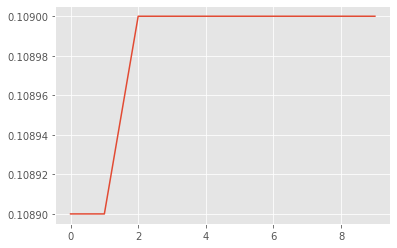

In [23]:
plt.style.use('ggplot')
dfs = analysis.trial_dataframes
[d.mean_accuracy.plot() for d in dfs.values()]

In [30]:
analysis = tune.run(
    train_mnist,
    num_samples=20,
    scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    config=search_space)

# Obtain a trial dataframe from all run trials of this `tune.run` call.
dfs = analysis.trial_dataframes

Trial name,status,loc,lr,momentum
train_mnist_c7613_00000,PENDING,,1.67494e-06,0.523181
train_mnist_c7613_00001,PENDING,,4.00504e-09,0.188056
train_mnist_c7613_00002,PENDING,,3.78682e-10,0.712934
train_mnist_c7613_00003,PENDING,,0.000925498,0.812313
train_mnist_c7613_00004,PENDING,,3.97637e-07,0.563474
train_mnist_c7613_00005,PENDING,,0.00206648,0.866366
train_mnist_c7613_00006,PENDING,,2.21336e-05,0.55356
train_mnist_c7613_00007,PENDING,,1.23968e-08,0.685055
train_mnist_c7613_00008,PENDING,,0.00861257,0.228381
train_mnist_c7613_00009,PENDING,,9.66043e-06,0.418431


Trial name,status,loc,lr,momentum
train_mnist_c7613_00000,RUNNING,,1.67494e-06,0.523181
train_mnist_c7613_00001,RUNNING,,4.00504e-09,0.188056
train_mnist_c7613_00002,RUNNING,,3.78682e-10,0.712934
train_mnist_c7613_00003,RUNNING,,0.000925498,0.812313
train_mnist_c7613_00004,RUNNING,,3.97637e-07,0.563474
train_mnist_c7613_00005,RUNNING,,0.00206648,0.866366
train_mnist_c7613_00006,RUNNING,,2.21336e-05,0.55356
train_mnist_c7613_00007,RUNNING,,1.23968e-08,0.685055
train_mnist_c7613_00008,PENDING,,0.00861257,0.228381
train_mnist_c7613_00009,PENDING,,9.66043e-06,0.418431


Result for train_mnist_c7613_00002:
  date: 2021-10-31_17-54-16
  done: false
  experiment_id: 123e44ca46f54a6ca1f539e4ada46d40
  hostname: tobi-yoga
  iterations_since_restore: 1
  mean_accuracy: 0.1021
  node_ip: 10.80.1.25
  pid: 19134
  time_since_restore: 5.471258878707886
  time_this_iter_s: 5.471258878707886
  time_total_s: 5.471258878707886
  timestamp: 1635695656
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c7613_00002
  
Result for train_mnist_c7613_00003:
  date: 2021-10-31_17-54-16
  done: false
  experiment_id: 9b4b8ebbd2044be2b13c8158744cbf1d
  hostname: tobi-yoga
  iterations_since_restore: 1
  mean_accuracy: 0.151
  node_ip: 10.80.1.25
  pid: 19132
  time_since_restore: 5.6635026931762695
  time_this_iter_s: 5.6635026931762695
  time_total_s: 5.6635026931762695
  timestamp: 1635695656
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c7613_00003
  
Result for train_mnist_c7613_00005:
  date: 2021-10-31_17-54-17
  done: true
  experimen

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_c7613_00001,RUNNING,,4.00504e-09,0.188056,,,
train_mnist_c7613_00002,RUNNING,10.80.1.25:19134,3.78682e-10,0.712934,0.1021,1,5.47126
train_mnist_c7613_00003,RUNNING,10.80.1.25:19132,0.000925498,0.812313,0.151,1,5.6635
train_mnist_c7613_00004,RUNNING,10.80.1.25:19131,3.97637e-07,0.563474,0.122,1,6.37552
train_mnist_c7613_00006,RUNNING,10.80.1.25:19133,2.21336e-05,0.55356,0.131,1,5.93498
train_mnist_c7613_00008,RUNNING,,0.00861257,0.228381,,,
train_mnist_c7613_00009,RUNNING,,9.66043e-06,0.418431,,,
train_mnist_c7613_00010,PENDING,,0.014478,0.751493,,,
train_mnist_c7613_00011,PENDING,,1.66351e-09,0.722286,,,
train_mnist_c7613_00012,PENDING,,5.44293e-08,0.126837,,,


Result for train_mnist_c7613_00001:
  date: 2021-10-31_17-54-17
  done: true
  experiment_id: 7b66c8fa143a4e8c9af49204df223584
  hostname: tobi-yoga
  iterations_since_restore: 1
  mean_accuracy: 0.0621
  node_ip: 10.80.1.25
  pid: 19130
  time_since_restore: 6.38964581489563
  time_this_iter_s: 6.38964581489563
  time_total_s: 6.38964581489563
  timestamp: 1635695657
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c7613_00001
  
Result for train_mnist_c7613_00002:
  date: 2021-10-31_17-54-21
  done: false
  experiment_id: 123e44ca46f54a6ca1f539e4ada46d40
  hostname: tobi-yoga
  iterations_since_restore: 2
  mean_accuracy: 0.1021
  node_ip: 10.80.1.25
  pid: 19134
  time_since_restore: 10.855062007904053
  time_this_iter_s: 5.383803129196167
  time_total_s: 10.855062007904053
  timestamp: 1635695661
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: c7613_00002
  
Result for train_mnist_c7613_00003:
  date: 2021-10-31_17-54-22
  done: false
  experiment_i

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_c7613_00002,RUNNING,10.80.1.25:19134,3.78682e-10,0.712934,0.1021,2,10.8551
train_mnist_c7613_00003,RUNNING,10.80.1.25:19132,0.000925498,0.812313,0.1734,2,11.115
train_mnist_c7613_00004,RUNNING,10.80.1.25:19131,3.97637e-07,0.563474,0.1221,2,11.8462
train_mnist_c7613_00006,RUNNING,10.80.1.25:19133,2.21336e-05,0.55356,0.1318,2,10.9932
train_mnist_c7613_00008,RUNNING,,0.00861257,0.228381,,,
train_mnist_c7613_00009,RUNNING,,9.66043e-06,0.418431,,,
train_mnist_c7613_00010,RUNNING,,0.014478,0.751493,,,
train_mnist_c7613_00011,RUNNING,,1.66351e-09,0.722286,,,
train_mnist_c7613_00012,PENDING,,5.44293e-08,0.126837,,,
train_mnist_c7613_00013,PENDING,,1.36225e-08,0.854199,,,


Result for train_mnist_c7613_00009:
  date: 2021-10-31_17-54-26
  done: true
  experiment_id: 259ab06a69444d0f80c81a7f6dd6175f
  hostname: tobi-yoga
  iterations_since_restore: 1
  mean_accuracy: 0.1026
  node_ip: 10.80.1.25
  pid: 19477
  time_since_restore: 5.73348331451416
  time_this_iter_s: 5.73348331451416
  time_total_s: 5.73348331451416
  timestamp: 1635695666
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c7613_00009
  
Result for train_mnist_c7613_00008:
  date: 2021-10-31_17-54-26
  done: false
  experiment_id: b80fcf68d0024be08a9684ea282fd536
  hostname: tobi-yoga
  iterations_since_restore: 1
  mean_accuracy: 0.2004
  node_ip: 10.80.1.25
  pid: 19470
  time_since_restore: 5.719652414321899
  time_this_iter_s: 5.719652414321899
  time_total_s: 5.719652414321899
  timestamp: 1635695666
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c7613_00008
  
Result for train_mnist_c7613_00011:
  date: 2021-10-31_17-54-27
  done: true
  experiment_id: 

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_c7613_00002,RUNNING,10.80.1.25:19134,3.78682e-10,0.712934,0.1021,3,15.8282
train_mnist_c7613_00003,RUNNING,10.80.1.25:19132,0.000925498,0.812313,0.2181,3,16.3992
train_mnist_c7613_00004,RUNNING,10.80.1.25:19131,3.97637e-07,0.563474,0.1221,3,17.042
train_mnist_c7613_00006,RUNNING,10.80.1.25:19133,2.21336e-05,0.55356,0.1327,3,15.903
train_mnist_c7613_00008,RUNNING,10.80.1.25:19470,0.00861257,0.228381,0.2004,1,5.71965
train_mnist_c7613_00010,RUNNING,10.80.1.25:19494,0.014478,0.751493,0.3886,1,5.57451
train_mnist_c7613_00012,RUNNING,,5.44293e-08,0.126837,,,
train_mnist_c7613_00013,RUNNING,,1.36225e-08,0.854199,,,
train_mnist_c7613_00014,PENDING,,6.84395e-09,0.583502,,,
train_mnist_c7613_00015,PENDING,,0.000442433,0.390402,,,


Result for train_mnist_c7613_00008:
  date: 2021-10-31_17-54-31
  done: false
  experiment_id: b80fcf68d0024be08a9684ea282fd536
  hostname: tobi-yoga
  iterations_since_restore: 2
  mean_accuracy: 0.3012
  node_ip: 10.80.1.25
  pid: 19470
  time_since_restore: 11.059279918670654
  time_this_iter_s: 5.339627504348755
  time_total_s: 11.059279918670654
  timestamp: 1635695671
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: c7613_00008
  
Result for train_mnist_c7613_00002:
  date: 2021-10-31_17-54-32
  done: false
  experiment_id: 123e44ca46f54a6ca1f539e4ada46d40
  hostname: tobi-yoga
  iterations_since_restore: 4
  mean_accuracy: 0.1021
  node_ip: 10.80.1.25
  pid: 19134
  time_since_restore: 21.19657826423645
  time_this_iter_s: 5.368402719497681
  time_total_s: 21.19657826423645
  timestamp: 1635695672
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: c7613_00002
  
Result for train_mnist_c7613_00003:
  date: 2021-10-31_17-54-32
  done: false
  experime

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_c7613_00002,RUNNING,10.80.1.25:19134,3.78682e-10,0.712934,0.1021,4,21.1966
train_mnist_c7613_00003,RUNNING,10.80.1.25:19132,0.000925498,0.812313,0.2804,4,21.618
train_mnist_c7613_00004,RUNNING,10.80.1.25:19131,3.97637e-07,0.563474,0.1221,3,17.042
train_mnist_c7613_00008,RUNNING,10.80.1.25:19470,0.00861257,0.228381,0.3012,2,11.0593
train_mnist_c7613_00010,RUNNING,10.80.1.25:19494,0.014478,0.751493,0.7031,2,10.7423
train_mnist_c7613_00012,RUNNING,,5.44293e-08,0.126837,,,
train_mnist_c7613_00013,RUNNING,,1.36225e-08,0.854199,,,
train_mnist_c7613_00014,PENDING,,6.84395e-09,0.583502,,,
train_mnist_c7613_00015,PENDING,,0.000442433,0.390402,,,
train_mnist_c7613_00016,PENDING,,3.09232e-06,0.69641,,,


Result for train_mnist_c7613_00004:
  date: 2021-10-31_17-54-33
  done: true
  experiment_id: ba6bc86917c547acac4e3982f970d70a
  hostname: tobi-yoga
  iterations_since_restore: 4
  mean_accuracy: 0.1221
  node_ip: 10.80.1.25
  pid: 19131
  time_since_restore: 22.96696400642395
  time_this_iter_s: 5.924925804138184
  time_total_s: 22.96696400642395
  timestamp: 1635695673
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: c7613_00004
  
Result for train_mnist_c7613_00012:
  date: 2021-10-31_17-54-36
  done: true
  experiment_id: ac81c2e89dce4caf8c96805375a54206
  hostname: tobi-yoga
  iterations_since_restore: 1
  mean_accuracy: 0.0667
  node_ip: 10.80.1.25
  pid: 19659
  time_since_restore: 6.295845031738281
  time_this_iter_s: 6.295845031738281
  time_total_s: 6.295845031738281
  timestamp: 1635695676
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c7613_00012
  
Result for train_mnist_c7613_00013:
  date: 2021-10-31_17-54-37
  done: true
  experiment_id

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_c7613_00002,RUNNING,10.80.1.25:19134,3.78682e-10,0.712934,0.1021,4,21.1966
train_mnist_c7613_00003,RUNNING,10.80.1.25:19132,0.000925498,0.812313,0.2804,4,21.618
train_mnist_c7613_00008,RUNNING,10.80.1.25:19470,0.00861257,0.228381,0.3012,2,11.0593
train_mnist_c7613_00010,RUNNING,10.80.1.25:19494,0.014478,0.751493,0.7031,2,10.7423
train_mnist_c7613_00014,RUNNING,,6.84395e-09,0.583502,,,
train_mnist_c7613_00015,RUNNING,,0.000442433,0.390402,,,
train_mnist_c7613_00016,RUNNING,,3.09232e-06,0.69641,,,
train_mnist_c7613_00017,RUNNING,,0.167406,0.832788,,,
train_mnist_c7613_00018,PENDING,,0.170713,0.872978,,,
train_mnist_c7613_00019,PENDING,,1.09439e-07,0.763757,,,


Result for train_mnist_c7613_00003:
  date: 2021-10-31_17-54-38
  done: false
  experiment_id: 9b4b8ebbd2044be2b13c8158744cbf1d
  hostname: tobi-yoga
  iterations_since_restore: 5
  mean_accuracy: 0.3452
  node_ip: 10.80.1.25
  pid: 19132
  time_since_restore: 27.75853967666626
  time_this_iter_s: 6.140542984008789
  time_total_s: 27.75853967666626
  timestamp: 1635695678
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: c7613_00003
  
Result for train_mnist_c7613_00002:
  date: 2021-10-31_17-54-38
  done: false
  experiment_id: 123e44ca46f54a6ca1f539e4ada46d40
  hostname: tobi-yoga
  iterations_since_restore: 5
  mean_accuracy: 0.1021
  node_ip: 10.80.1.25
  pid: 19134
  time_since_restore: 27.93957543373108
  time_this_iter_s: 6.742997169494629
  time_total_s: 27.93957543373108
  timestamp: 1635695678
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: c7613_00002
  
Result for train_mnist_c7613_00008:
  date: 2021-10-31_17-54-39
  done: false
  experiment

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_c7613_00002,RUNNING,10.80.1.25:19134,3.78682e-10,0.712934,0.1021,5,27.9396
train_mnist_c7613_00003,RUNNING,10.80.1.25:19132,0.000925498,0.812313,0.3452,5,27.7585
train_mnist_c7613_00008,RUNNING,10.80.1.25:19470,0.00861257,0.228381,0.386,3,18.4421
train_mnist_c7613_00010,RUNNING,10.80.1.25:19494,0.014478,0.751493,0.7714,3,17.3229
train_mnist_c7613_00014,RUNNING,,6.84395e-09,0.583502,,,
train_mnist_c7613_00015,RUNNING,,0.000442433,0.390402,,,
train_mnist_c7613_00016,RUNNING,,3.09232e-06,0.69641,,,
train_mnist_c7613_00017,RUNNING,,0.167406,0.832788,,,
train_mnist_c7613_00018,PENDING,,0.170713,0.872978,,,
train_mnist_c7613_00019,PENDING,,1.09439e-07,0.763757,,,


Result for train_mnist_c7613_00014:
  date: 2021-10-31_17-54-45
  done: true
  experiment_id: f46219188b6a4311bf11b43f6076b454
  hostname: tobi-yoga
  iterations_since_restore: 1
  mean_accuracy: 0.0946
  node_ip: 10.80.1.25
  pid: 19755
  time_since_restore: 7.712987422943115
  time_this_iter_s: 7.712987422943115
  time_total_s: 7.712987422943115
  timestamp: 1635695685
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c7613_00014
  
Result for train_mnist_c7613_00003:
  date: 2021-10-31_17-54-46
  done: false
  experiment_id: 9b4b8ebbd2044be2b13c8158744cbf1d
  hostname: tobi-yoga
  iterations_since_restore: 6
  mean_accuracy: 0.4065
  node_ip: 10.80.1.25
  pid: 19132
  time_since_restore: 35.48755121231079
  time_this_iter_s: 7.729011535644531
  time_total_s: 35.48755121231079
  timestamp: 1635695686
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: c7613_00003
  
Result for train_mnist_c7613_00002:
  date: 2021-10-31_17-54-46
  done: false
  experiment_

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_c7613_00002,RUNNING,10.80.1.25:19134,3.78682e-10,0.712934,0.1021,6,35.3912
train_mnist_c7613_00003,RUNNING,10.80.1.25:19132,0.000925498,0.812313,0.4065,6,35.4876
train_mnist_c7613_00008,RUNNING,10.80.1.25:19470,0.00861257,0.228381,0.4838,4,26.0983
train_mnist_c7613_00010,RUNNING,10.80.1.25:19494,0.014478,0.751493,0.8201,4,24.8179
train_mnist_c7613_00016,RUNNING,10.80.1.25:19811,3.09232e-06,0.69641,0.1563,1,8.37444
train_mnist_c7613_00017,RUNNING,,0.167406,0.832788,,,
train_mnist_c7613_00018,RUNNING,,0.170713,0.872978,,,
train_mnist_c7613_00019,RUNNING,,1.09439e-07,0.763757,,,
train_mnist_c7613_00000,TERMINATED,,1.67494e-06,0.523181,0.1005,1,6.6017
train_mnist_c7613_00001,TERMINATED,,4.00504e-09,0.188056,0.0621,1,6.38965


Result for train_mnist_c7613_00017:
  date: 2021-10-31_17-54-50
  done: false
  experiment_id: bda9612aca0144729581e5591b57b2a7
  hostname: tobi-yoga
  iterations_since_restore: 1
  mean_accuracy: 0.7129
  node_ip: 10.80.1.25
  pid: 19840
  time_since_restore: 8.146170854568481
  time_this_iter_s: 8.146170854568481
  time_total_s: 8.146170854568481
  timestamp: 1635695690
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c7613_00017
  
Result for train_mnist_c7613_00008:
  date: 2021-10-31_17-54-54
  done: false
  experiment_id: b80fcf68d0024be08a9684ea282fd536
  hostname: tobi-yoga
  iterations_since_restore: 5
  mean_accuracy: 0.5428
  node_ip: 10.80.1.25
  pid: 19470
  time_since_restore: 33.742652893066406
  time_this_iter_s: 7.644397974014282
  time_total_s: 33.742652893066406
  timestamp: 1635695694
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: c7613_00008
  
Result for train_mnist_c7613_00003:
  date: 2021-10-31_17-54-54
  done: false
  experime

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_c7613_00002,RUNNING,10.80.1.25:19134,3.78682e-10,0.712934,0.1021,7,43.846
train_mnist_c7613_00003,RUNNING,10.80.1.25:19132,0.000925498,0.812313,0.4721,7,43.8973
train_mnist_c7613_00008,RUNNING,10.80.1.25:19470,0.00861257,0.228381,0.5428,5,33.7427
train_mnist_c7613_00010,RUNNING,10.80.1.25:19494,0.014478,0.751493,0.8508,5,32.9873
train_mnist_c7613_00016,RUNNING,10.80.1.25:19811,3.09232e-06,0.69641,0.1563,1,8.37444
train_mnist_c7613_00017,RUNNING,10.80.1.25:19840,0.167406,0.832788,0.7129,1,8.14617
train_mnist_c7613_00018,RUNNING,,0.170713,0.872978,,,
train_mnist_c7613_00019,RUNNING,,1.09439e-07,0.763757,,,
train_mnist_c7613_00000,TERMINATED,,1.67494e-06,0.523181,0.1005,1,6.6017
train_mnist_c7613_00001,TERMINATED,,4.00504e-09,0.188056,0.0621,1,6.38965


Result for train_mnist_c7613_00016:
  date: 2021-10-31_17-54-57
  done: false
  experiment_id: 9c2d804ef02b4858a53696c6ae5a0391
  hostname: tobi-yoga
  iterations_since_restore: 2
  mean_accuracy: 0.1566
  node_ip: 10.80.1.25
  pid: 19811
  time_since_restore: 16.715694665908813
  time_this_iter_s: 8.341252565383911
  time_total_s: 16.715694665908813
  timestamp: 1635695697
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: c7613_00016
  
Result for train_mnist_c7613_00017:
  date: 2021-10-31_17-54-58
  done: false
  experiment_id: bda9612aca0144729581e5591b57b2a7
  hostname: tobi-yoga
  iterations_since_restore: 2
  mean_accuracy: 0.7784
  node_ip: 10.80.1.25
  pid: 19840
  time_since_restore: 16.567031145095825
  time_this_iter_s: 8.420860290527344
  time_total_s: 16.567031145095825
  timestamp: 1635695698
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: c7613_00017
  
Result for train_mnist_c7613_00018:
  date: 2021-10-31_17-54-59
  done: false
  experi

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_c7613_00002,RUNNING,10.80.1.25:19134,3.78682e-10,0.712934,0.1021,7,43.846
train_mnist_c7613_00003,RUNNING,10.80.1.25:19132,0.000925498,0.812313,0.4721,7,43.8973
train_mnist_c7613_00008,RUNNING,10.80.1.25:19470,0.00861257,0.228381,0.5428,5,33.7427
train_mnist_c7613_00010,RUNNING,10.80.1.25:19494,0.014478,0.751493,0.8508,5,32.9873
train_mnist_c7613_00016,RUNNING,10.80.1.25:19811,3.09232e-06,0.69641,0.1566,2,16.7157
train_mnist_c7613_00017,RUNNING,10.80.1.25:19840,0.167406,0.832788,0.7784,2,16.567
train_mnist_c7613_00018,RUNNING,10.80.1.25:19933,0.170713,0.872978,0.6943,1,9.4348
train_mnist_c7613_00000,TERMINATED,,1.67494e-06,0.523181,0.1005,1,6.6017
train_mnist_c7613_00001,TERMINATED,,4.00504e-09,0.188056,0.0621,1,6.38965
train_mnist_c7613_00004,TERMINATED,,3.97637e-07,0.563474,0.1221,4,22.967


Result for train_mnist_c7613_00003:
  date: 2021-10-31_17-55-02
  done: false
  experiment_id: 9b4b8ebbd2044be2b13c8158744cbf1d
  hostname: tobi-yoga
  iterations_since_restore: 8
  mean_accuracy: 0.5154
  node_ip: 10.80.1.25
  pid: 19132
  time_since_restore: 51.2239727973938
  time_this_iter_s: 7.326679229736328
  time_total_s: 51.2239727973938
  timestamp: 1635695702
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: c7613_00003
  
Result for train_mnist_c7613_00008:
  date: 2021-10-31_17-55-02
  done: false
  experiment_id: b80fcf68d0024be08a9684ea282fd536
  hostname: tobi-yoga
  iterations_since_restore: 6
  mean_accuracy: 0.6324
  node_ip: 10.80.1.25
  pid: 19470
  time_since_restore: 41.706449031829834
  time_this_iter_s: 7.963796138763428
  time_total_s: 41.706449031829834
  timestamp: 1635695702
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: c7613_00008
  
Result for train_mnist_c7613_00010:
  date: 2021-10-31_17-55-02
  done: false
  experiment

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_c7613_00002,RUNNING,10.80.1.25:19134,3.78682e-10,0.712934,0.1021,8,51.8619
train_mnist_c7613_00003,RUNNING,10.80.1.25:19132,0.000925498,0.812313,0.5154,8,51.224
train_mnist_c7613_00008,RUNNING,10.80.1.25:19470,0.00861257,0.228381,0.6324,6,41.7064
train_mnist_c7613_00010,RUNNING,10.80.1.25:19494,0.014478,0.751493,0.8435,6,40.6418
train_mnist_c7613_00016,RUNNING,10.80.1.25:19811,3.09232e-06,0.69641,0.1566,3,23.2842
train_mnist_c7613_00017,RUNNING,10.80.1.25:19840,0.167406,0.832788,0.8367,3,23.1438
train_mnist_c7613_00018,RUNNING,10.80.1.25:19933,0.170713,0.872978,0.7762,2,15.8579
train_mnist_c7613_00000,TERMINATED,,1.67494e-06,0.523181,0.1005,1,6.6017
train_mnist_c7613_00001,TERMINATED,,4.00504e-09,0.188056,0.0621,1,6.38965
train_mnist_c7613_00004,TERMINATED,,3.97637e-07,0.563474,0.1221,4,22.967


Result for train_mnist_c7613_00003:
  date: 2021-10-31_17-55-08
  done: false
  experiment_id: 9b4b8ebbd2044be2b13c8158744cbf1d
  hostname: tobi-yoga
  iterations_since_restore: 9
  mean_accuracy: 0.547
  node_ip: 10.80.1.25
  pid: 19132
  time_since_restore: 57.69719672203064
  time_this_iter_s: 6.473223924636841
  time_total_s: 57.69719672203064
  timestamp: 1635695708
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: c7613_00003
  
Result for train_mnist_c7613_00010:
  date: 2021-10-31_17-55-08
  done: false
  experiment_id: 64ffbad534ce42d2ba004cc11cc0c1d7
  hostname: tobi-yoga
  iterations_since_restore: 7
  mean_accuracy: 0.8634
  node_ip: 10.80.1.25
  pid: 19494
  time_since_restore: 46.903478384017944
  time_this_iter_s: 6.261651992797852
  time_total_s: 46.903478384017944
  timestamp: 1635695708
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: c7613_00010
  
Result for train_mnist_c7613_00008:
  date: 2021-10-31_17-55-08
  done: false
  experimen

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_c7613_00002,RUNNING,10.80.1.25:19134,3.78682e-10,0.712934,0.1021,9,58.4018
train_mnist_c7613_00003,RUNNING,10.80.1.25:19132,0.000925498,0.812313,0.547,9,57.6972
train_mnist_c7613_00008,RUNNING,10.80.1.25:19470,0.00861257,0.228381,0.6791,7,48.1969
train_mnist_c7613_00010,RUNNING,10.80.1.25:19494,0.014478,0.751493,0.8634,7,46.9035
train_mnist_c7613_00017,RUNNING,10.80.1.25:19840,0.167406,0.832788,0.8874,4,29.1488
train_mnist_c7613_00018,RUNNING,10.80.1.25:19933,0.170713,0.872978,0.8039,3,21.4874
train_mnist_c7613_00000,TERMINATED,,1.67494e-06,0.523181,0.1005,1,6.6017
train_mnist_c7613_00001,TERMINATED,,4.00504e-09,0.188056,0.0621,1,6.38965
train_mnist_c7613_00004,TERMINATED,,3.97637e-07,0.563474,0.1221,4,22.967
train_mnist_c7613_00005,TERMINATED,,0.00206648,0.866366,0.0932,1,6.20697


Result for train_mnist_c7613_00010:
  date: 2021-10-31_17-55-13
  done: false
  experiment_id: 64ffbad534ce42d2ba004cc11cc0c1d7
  hostname: tobi-yoga
  iterations_since_restore: 8
  mean_accuracy: 0.8586
  node_ip: 10.80.1.25
  pid: 19494
  time_since_restore: 51.93722224235535
  time_this_iter_s: 5.033743858337402
  time_total_s: 51.93722224235535
  timestamp: 1635695713
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: c7613_00010
  
Result for train_mnist_c7613_00003:
  date: 2021-10-31_17-55-13
  done: false
  experiment_id: 9b4b8ebbd2044be2b13c8158744cbf1d
  hostname: tobi-yoga
  iterations_since_restore: 10
  mean_accuracy: 0.5863
  node_ip: 10.80.1.25
  pid: 19132
  time_since_restore: 62.97322058677673
  time_this_iter_s: 5.276023864746094
  time_total_s: 62.97322058677673
  timestamp: 1635695713
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: c7613_00003
  
Result for train_mnist_c7613_00003:
  date: 2021-10-31_17-55-13
  done: true
  experimen

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_c7613_00008,RUNNING,10.80.1.25:19470,0.00861257,0.228381,0.7467,9,56.9981
train_mnist_c7613_00010,RUNNING,10.80.1.25:19494,0.014478,0.751493,0.871,9,55.4343
train_mnist_c7613_00017,RUNNING,10.80.1.25:19840,0.167406,0.832788,0.8867,5,33.3492
train_mnist_c7613_00018,RUNNING,10.80.1.25:19933,0.170713,0.872978,0.6983,4,25.8658
train_mnist_c7613_00000,TERMINATED,,1.67494e-06,0.523181,0.1005,1,6.6017
train_mnist_c7613_00001,TERMINATED,,4.00504e-09,0.188056,0.0621,1,6.38965
train_mnist_c7613_00002,TERMINATED,,3.78682e-10,0.712934,0.1021,10,63.421
train_mnist_c7613_00003,TERMINATED,,0.000925498,0.812313,0.5863,10,62.9732
train_mnist_c7613_00004,TERMINATED,,3.97637e-07,0.563474,0.1221,4,22.967
train_mnist_c7613_00005,TERMINATED,,0.00206648,0.866366,0.0932,1,6.20697


Result for train_mnist_c7613_00017:
  date: 2021-10-31_17-55-18
  done: false
  experiment_id: bda9612aca0144729581e5591b57b2a7
  hostname: tobi-yoga
  iterations_since_restore: 6
  mean_accuracy: 0.8859
  node_ip: 10.80.1.25
  pid: 19840
  time_since_restore: 36.65489959716797
  time_this_iter_s: 3.305713176727295
  time_total_s: 36.65489959716797
  timestamp: 1635695718
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: c7613_00017
  
Result for train_mnist_c7613_00018:
  date: 2021-10-31_17-55-19
  done: false
  experiment_id: 9515db3e513d42168a63012b102c1f51
  hostname: tobi-yoga
  iterations_since_restore: 5
  mean_accuracy: 0.862
  node_ip: 10.80.1.25
  pid: 19933
  time_since_restore: 29.47796630859375
  time_this_iter_s: 3.6121604442596436
  time_total_s: 29.47796630859375
  timestamp: 1635695719
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: c7613_00018
  
Result for train_mnist_c7613_00010:
  date: 2021-10-31_17-55-21
  done: false
  experiment

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_c7613_00017,RUNNING,10.80.1.25:19840,0.167406,0.832788,0.9068,7,40.2018
train_mnist_c7613_00018,RUNNING,10.80.1.25:19933,0.170713,0.872978,0.8538,6,32.6251
train_mnist_c7613_00000,TERMINATED,,1.67494e-06,0.523181,0.1005,1,6.6017
train_mnist_c7613_00001,TERMINATED,,4.00504e-09,0.188056,0.0621,1,6.38965
train_mnist_c7613_00002,TERMINATED,,3.78682e-10,0.712934,0.1021,10,63.421
train_mnist_c7613_00003,TERMINATED,,0.000925498,0.812313,0.5863,10,62.9732
train_mnist_c7613_00004,TERMINATED,,3.97637e-07,0.563474,0.1221,4,22.967
train_mnist_c7613_00005,TERMINATED,,0.00206648,0.866366,0.0932,1,6.20697
train_mnist_c7613_00006,TERMINATED,,2.21336e-05,0.55356,0.1342,4,22.0182
train_mnist_c7613_00007,TERMINATED,,1.23968e-08,0.685055,0.0904,1,5.47818


Result for train_mnist_c7613_00017:
  date: 2021-10-31_17-55-24
  done: false
  experiment_id: bda9612aca0144729581e5591b57b2a7
  hostname: tobi-yoga
  iterations_since_restore: 8
  mean_accuracy: 0.9164
  node_ip: 10.80.1.25
  pid: 19840
  time_since_restore: 42.570292711257935
  time_this_iter_s: 2.3685414791107178
  time_total_s: 42.570292711257935
  timestamp: 1635695724
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: c7613_00017
  
Result for train_mnist_c7613_00018:
  date: 2021-10-31_17-55-25
  done: false
  experiment_id: 9515db3e513d42168a63012b102c1f51
  hostname: tobi-yoga
  iterations_since_restore: 7
  mean_accuracy: 0.8995
  node_ip: 10.80.1.25
  pid: 19933
  time_since_restore: 34.97875618934631
  time_this_iter_s: 2.3536829948425293
  time_total_s: 34.97875618934631
  timestamp: 1635695725
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: c7613_00018
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_c7613_00017,RUNNING,10.80.1.25:19840,0.167406,0.832788,0.8962,9,45.3212
train_mnist_c7613_00018,RUNNING,10.80.1.25:19933,0.170713,0.872978,0.8922,8,37.7143
train_mnist_c7613_00000,TERMINATED,,1.67494e-06,0.523181,0.1005,1,6.6017
train_mnist_c7613_00001,TERMINATED,,4.00504e-09,0.188056,0.0621,1,6.38965
train_mnist_c7613_00002,TERMINATED,,3.78682e-10,0.712934,0.1021,10,63.421
train_mnist_c7613_00003,TERMINATED,,0.000925498,0.812313,0.5863,10,62.9732
train_mnist_c7613_00004,TERMINATED,,3.97637e-07,0.563474,0.1221,4,22.967
train_mnist_c7613_00005,TERMINATED,,0.00206648,0.866366,0.0932,1,6.20697
train_mnist_c7613_00006,TERMINATED,,2.21336e-05,0.55356,0.1342,4,22.0182
train_mnist_c7613_00007,TERMINATED,,1.23968e-08,0.685055,0.0904,1,5.47818


Result for train_mnist_c7613_00017:
  date: 2021-10-31_17-55-30
  done: false
  experiment_id: bda9612aca0144729581e5591b57b2a7
  hostname: tobi-yoga
  iterations_since_restore: 10
  mean_accuracy: 0.9211
  node_ip: 10.80.1.25
  pid: 19840
  time_since_restore: 47.79705834388733
  time_this_iter_s: 2.47589111328125
  time_total_s: 47.79705834388733
  timestamp: 1635695730
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: c7613_00017
  
Result for train_mnist_c7613_00017:
  date: 2021-10-31_17-55-30
  done: true
  experiment_id: bda9612aca0144729581e5591b57b2a7
  experiment_tag: 17_lr=0.16741,momentum=0.83279
  hostname: tobi-yoga
  iterations_since_restore: 10
  mean_accuracy: 0.9211
  node_ip: 10.80.1.25
  pid: 19840
  time_since_restore: 47.79705834388733
  time_this_iter_s: 2.47589111328125
  time_total_s: 47.79705834388733
  timestamp: 1635695730
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: c7613_00017
  
Result for train_mnist_c7613_00018:
  da

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_c7613_00000,TERMINATED,,1.67494e-06,0.523181,0.1005,1,6.6017
train_mnist_c7613_00001,TERMINATED,,4.00504e-09,0.188056,0.0621,1,6.38965
train_mnist_c7613_00002,TERMINATED,,3.78682e-10,0.712934,0.1021,10,63.421
train_mnist_c7613_00003,TERMINATED,,0.000925498,0.812313,0.5863,10,62.9732
train_mnist_c7613_00004,TERMINATED,,3.97637e-07,0.563474,0.1221,4,22.967
train_mnist_c7613_00005,TERMINATED,,0.00206648,0.866366,0.0932,1,6.20697
train_mnist_c7613_00006,TERMINATED,,2.21336e-05,0.55356,0.1342,4,22.0182
train_mnist_c7613_00007,TERMINATED,,1.23968e-08,0.685055,0.0904,1,5.47818
train_mnist_c7613_00008,TERMINATED,,0.00861257,0.228381,0.7643,10,60.7955
train_mnist_c7613_00009,TERMINATED,,9.66043e-06,0.418431,0.1026,1,5.73348


2021-10-31 17:55:32,591	INFO tune.py:617 -- Total run time: 85.82 seconds (85.66 seconds for the tuning loop).


Text(0, 0.5, 'Mean Accuracy')

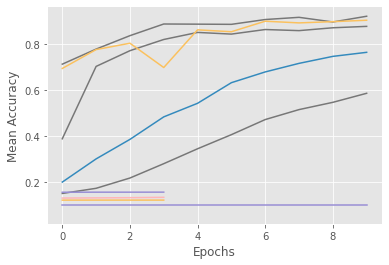

In [31]:
# Plot by epoch
plt.style.use('ggplot')
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Accuracy")

In [32]:
from hyperopt import hp
from ray.tune.suggest.hyperopt import HyperOptSearch

space = {
    "lr": hp.loguniform("lr", 1e-10, 0.1),
    "momentum": hp.uniform("momentum", 0.1, 0.9),
}

hyperopt_search = HyperOptSearch(space, metric="mean_accuracy", mode="max")

# delivers somehow bad performance!
# analysis = tune.run(train_mnist, num_samples=10, search_alg=hyperopt_search)

Text(0, 0.5, 'Mean Accuracy')

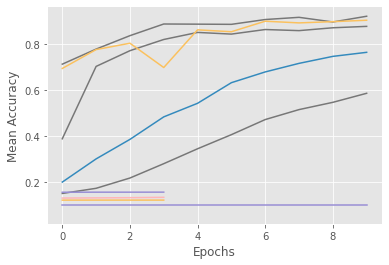

In [33]:
# Plot by epoch

ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Accuracy")

In [42]:
import os

df = analysis.results_df
logdir = analysis.get_best_logdir("mean_accuracy", mode="max")
state_dict = torch.load(os.path.join(logdir, "model.pth"))

model = ConvNet()
model.load_state_dict(state_dict)
print(analysis.get_best_trial("mean_accuracy", mode="max").last_result['mean_accuracy'])
print(analysis.get_best_config("mean_accuracy", mode="max"))

0.9211
{'lr': 0.1674057571254761, 'momentum': 0.8327876487494963}


In [43]:
# Explore
# https://github.com/Eng-Abdelrahman-M/handwritten_digit_recognition/blob/main/handwritten_digit_recognition.ipynb

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
Label:  7


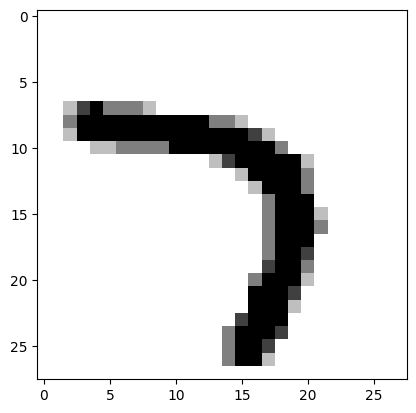

In [44]:
# Data Setup
mnist_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307, ), (0.3081, ))])

test_loader = DataLoader(
    datasets.MNIST("~/data", train=False, transform=mnist_transforms),
    batch_size=64,
    shuffle=True)
    
dataiter = iter(test_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)
print("Label: ", labels[0].numpy())
plt.style.use('default')
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

In [ ]:
# Predict
# https://blog.machinfy.com/handwritten-digit-recognition-mnist-using-pytorch/

In [45]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().squeeze()
    plt.imshow(inp, cmap='gray_r')
    if title is not None:
        plt.title(title)

In [1]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            if torch.cuda.is_available():
                inputs = inputs.to(device)
                labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            #print(outputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(datasets.MNIST.classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model)

NameError: name 'model' is not defined